## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, we working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. we worke to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.copy()
df2 = df2[(((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False)
        & (((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) != False)]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated() == True].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop(1899,inplace = True)

In [14]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
pro_of_controlP = df2[df2.group == 'control'].converted.mean()
pro_of_controlP

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
pro_of_treatmentP = df2[df2.group == 'treatment'].converted.mean()
pro_of_treatmentP 

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The answer:** 

we can not say the new treatment page leads to more conversions because the conversion probability of both pages are approximately same 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 The null hypotheses(H0):
 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 <= 0.05 
 
 The alternative hypotheses(H1):
 𝑝𝑜𝑙𝑑 - 𝑝𝑛𝑒𝑤 > 0.05 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
new_p = df2.converted.mean()
new_p

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
old_p = df2.converted.mean()
old_p

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
Nnew = df2[df2.landing_page == 'new_page'].shape[0]
Nnew

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
Nold = df2[df2.landing_page == 'old_page'].shape[0]
Nold

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0, 1], p=[(1 - new_p), new_p], size=Nnew)
new_page_converted.mean()

0.12069368935379533

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], p=[(1 - old_p), old_p], size=Nold)
old_page_converted.mean()

0.11986315514131916

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
newOldDiff = new_page_converted.mean() - old_page_converted.mean()
newOldDiff

0.00083053421247616943

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
#create a 10000 random values and store them in p_diffs list
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size=Nnew,p=[1-old_p,old_p])
    old_page_converted = np.random.choice([0,1], size=Nold,p=[1-new_p,new_p])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())



i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

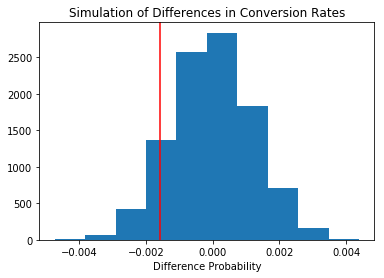

In [27]:
#plot Difference of Probability 
p_diffs = np.asarray(p_diffs)
plt.hist(p_diffs)
plt.title("Simulation of Differences in Conversion Rates")
plt.xlabel("Difference Probability")
tre_con_diff = pro_of_treatmentP - pro_of_controlP
plt.axvline(tre_con_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
p_diffs_portion = p_diffs >= tre_con_diff 
p_diffs_portion.mean()

0.90300000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The answer:**

To say that the old page is better than new page and to reject the null hypothesis, new page must prove a Type I error rate less than 5%.
but our value is 0.9 and it is too high to ignore, so we don not have enough  result to say there is convertion difference between the new page and old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_new = df2[df2.landing_page == 'new_page'].shape[0]
print('convert_old: ',convert_old,'\nconvert_new: ',convert_new,'\nn_old:\t', n_old,'\nn_new:\t' ,n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


convert_old:  17489 
convert_new:  17264 
n_old:	 145274 
n_new:	 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score , p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score , p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The answer:**

It's mean that :
- z-score is the standard deviation of the difference between convert_new and  convert_old data.
- p-value and z-score that we cumputed are agree with the value in j and k part.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The answer:**

because we have two possible values (0 or 1) so we will use a "Binary Logistic Regression"

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
#create dummies variables
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
reg_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = reg_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-27 09:54 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The answer:**

p-value = 0.19 , this value is differ from what we found in part II because we use one-tailed test in Part 2, and in Part 3 two-tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The answer:.**

adding other features can help us to decide which page is better and to find what feature affect in each page, so tere is no disadvantages to adding additional terms

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [34]:
#read a countries.csv and merge it with df2
countries_df = pd.read_csv('countries.csv')
merge_df = df2.set_index('user_id').join(countries_df.set_index('user_id'), sort = True)
merge_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
user_id,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,US
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,US
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,US
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,US
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,US


In [35]:
#countries in database
merge_df.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [36]:
#creating dummy variable
merge_df[['ca', 'uk', 'us']] = pd.get_dummies(merge_df['country'])
merge_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,ca,uk,us
user_id,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,US,0,0,1


In [37]:
merge_reg_mod = sm.Logit(merge_df['converted'], merge_df[['intercept', 'us','ca']])
merge_result = merge_reg_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [38]:
merge_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-27 09:54 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
us           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
ca           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

**The answer:**

for both countries ca and us the p-value is greater than 5% so country does not have an impact on conversion

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
''' the necessary additional columns to see if there is significant effects on conversion 
based on interaction between page and country'''
merge_df['us_page'] = merge_df['us'] * merge_df['ab_page']
merge_df['ca_page'] = merge_df['ca'] * merge_df['ab_page']
merge_df.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,ca,uk,us,us_page,ca_page
user_id,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,US,0,0,1,1,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,US,0,0,1,1,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,US,0,0,1,0,0
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,US,0,0,1,1,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,US,0,0,1,1,0


In [40]:
couontry_reg_mod = sm.Logit(merge_df['converted'], merge_df[['intercept', 'ab_page', 'us', 'ca','us_page','ca_page']])
couontry_result = couontry_reg_mod.fit()
couontry_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-27 09:54 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
us            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ca           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
us_page      -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
ca_page      -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

**The answer:**
    
all p-valuse are greater than 5% so the interaction between page and country does not have  significant effects on conversion

**Summary:**

After analysis this data we can conclude that there is no significant effects on conversion between new page and old page, base on results in all parts.maybe we can change the variables or add new one to get obvious results, but with this information I think keeping the old page is a good idea because no significant effects as I mentioned before.

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0